## 23.06.2023 Backpropagation in neural networks, PCA and k-means clustering

Copyright (C) 2023, B. Zeller-Plumhoff

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html) for more details.

This Jupyter Notebook was created by Berit Zeller-Plumhoff for the course "Data Science for Material Scientists" at Kiel University. 

Within the notebook, you will display the architecture of a neural network. Following that, we will implement the PCA and k-means clustering.

We begin by loading the required libraries.

In [1]:
import pandas as pd # library for organizing data
import numpy as np # library for numerial computations
from sklearn.model_selection import train_test_split, KFold, cross_val_score # this library enables the splitting of a data set into training and test data
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.covariance import EmpiricalCovariance
from numpy.linalg import eigh
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt # library for plotting (not interactive)

### Predicting metallicity

For classification of metallicit based on the material compositon, we will use the dataset based on the publication from [Zhuo et al., 2018](https://pubs.acs.org/doi/pdf/10.1021/acs.jpclett.8b00124)<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) that can be accessed through __matminer__. Have a look at last week's notebook to learn more about the dataset and __matminer__.

In this case, we will start by loading the pickle file which we prepared previously.

In [2]:
df=pd.read_pickle('ismetal_df.pkl')
df.head()

,formula,is_metal,composition,H,He,Li,Be,B,C,N,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,Ag(AuS)2,True,"(Ag, Au, S)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Ag(W3Br7)2,True,"(Ag, W, Br)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Ag0.5Ge1Pb1.75S4,False,"(Ag, Ge, Pb, S)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Ag0.5Ge1Pb1.75Se4,False,"(Ag, Ge, Pb, Se)",0.0,0,0.0,0.0,0.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Ag2BBr,True,"(Ag, B, Br)",0.0,0,0.0,0.0,0.25,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Assign the dataframe __without__ columns "formula" "is_metal" and "composition" to your feature variable X and the "is_metal" column to the observation y. Then split this data into training and test data.

In [3]:
# assign the variables
X=df.drop(["formula","is_metal","composition"],axis=1)
y=df["is_metal"]

# split your data sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

With trees and random forests we can determine the [__feature_importances__](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) in a straightforward manner. The following cell lets you compute the feature importances based on the mean decrease in Gini impurity for the random forests you have trained and plot them in descending order. How does this agree with the tree you plotted in the previous cell?

#### Neural network architecture

As a next step we want to better understand the architecture of the best neural network that we have created. Lets assess the weights of our 4 most relevant features until now, which appeared to be the content of Se, S, O and Te, as well as a less important feature, such as H. Using the __get_loc__ functionality, find the column index they correspond to. 

In [4]:
cols='H','Se','S','O','Te'
for c in cols:
    print(X.columns.get_loc(c))

0
33
15
7
51


How does the network architecture look, if you retrain the best classifier based on our initial train/test split? Can you draw a graph (including only these 5 input features)? To do so, use the NN_Vis.py file. The code in this file was taken from the entries of Milo and Oliver Wilken [here](https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network/37366154#37366154), and is available under a [CC BY-SA 3.0 license](https://creativecommons.org/licenses/by-sa/3.0/).

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


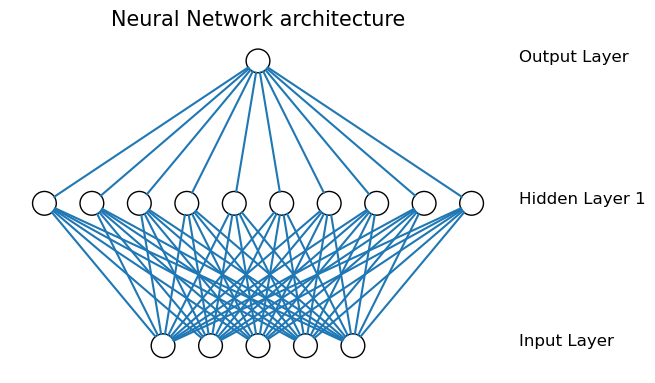

In [5]:
import NN_Vis as VisNN
clf=MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
clf.fit(X_train, y_train)
network_structure = np.hstack(([5], np.asarray(clf.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=VisNN.DrawNN(network_structure)
network.draw()

#### Partial training of network

If you are interested in obtaining the test loss during training of your network, you may use the __partial_fit__ functionality of the MLP classifier.

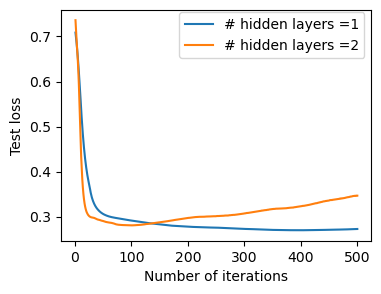

In [6]:
classes=np.unique(y)
# neural network (loop over number of hidden layers)
model_nn=[]
y_pred_nn=[]

fig, ax = plt.subplots(figsize=(4,3))
for k in range(1,3):
    hl=np.ones((k))*10
    model_nn_tmp = MLPClassifier(hidden_layer_sizes=(hl.astype(int)), max_iter=500, random_state=42)
    lloss=[]
    for j in range(1,501):
        model_nn_tmp.partial_fit(X_train, y_train,classes=classes)
        lloss.append(log_loss(y_test, model_nn_tmp.predict_proba(X_test)))
    plt.plot(np.arange(1,501),lloss,label='# hidden layers =%s' %(int(k)))
plt.ylabel('Test loss')
plt.xlabel('Number of iterations')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.02))
plt.show()

### Principal component analysis

In this part of the notebook, you will implement a PCA for the metallicity dataset. We begin by performing the standardization of our dataframe. For each feature $x$, compute $$x^{(i)}=\frac{x^{(i)}-\bar{x}}{\sigma(x)}$$ where $\bar{x}$ is the mean value of $x$ and $\sigma(x)$ the standard deviation. Replace NaNs with zeros.

In [7]:
# assign the variables
X_standard=(X-np.mean(X,axis=0))/np.std(X,axis=0)
X_standard=X_standard.fillna(0)
X_standard.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,-0.099517,0.0,-0.238919,-0.070369,-0.184602,-0.130079,-0.148656,-0.52753,-0.135336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.099517,0.0,-0.238919,-0.070369,-0.184602,-0.130079,-0.148656,-0.52753,-0.135336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.099517,0.0,-0.238919,-0.070369,-0.184602,-0.130079,-0.148656,-0.52753,-0.135336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.099517,0.0,-0.238919,-0.070369,-0.184602,-0.130079,-0.148656,-0.52753,-0.135336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.099517,0.0,-0.238919,-0.070369,2.602434,-0.130079,-0.148656,-0.52753,-0.135336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The next step in the PCA is to compute the covariance matrix. Use the [__numpy covariance__](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) to do so. Display the covariance matrix, including axes labels and a colour bar.

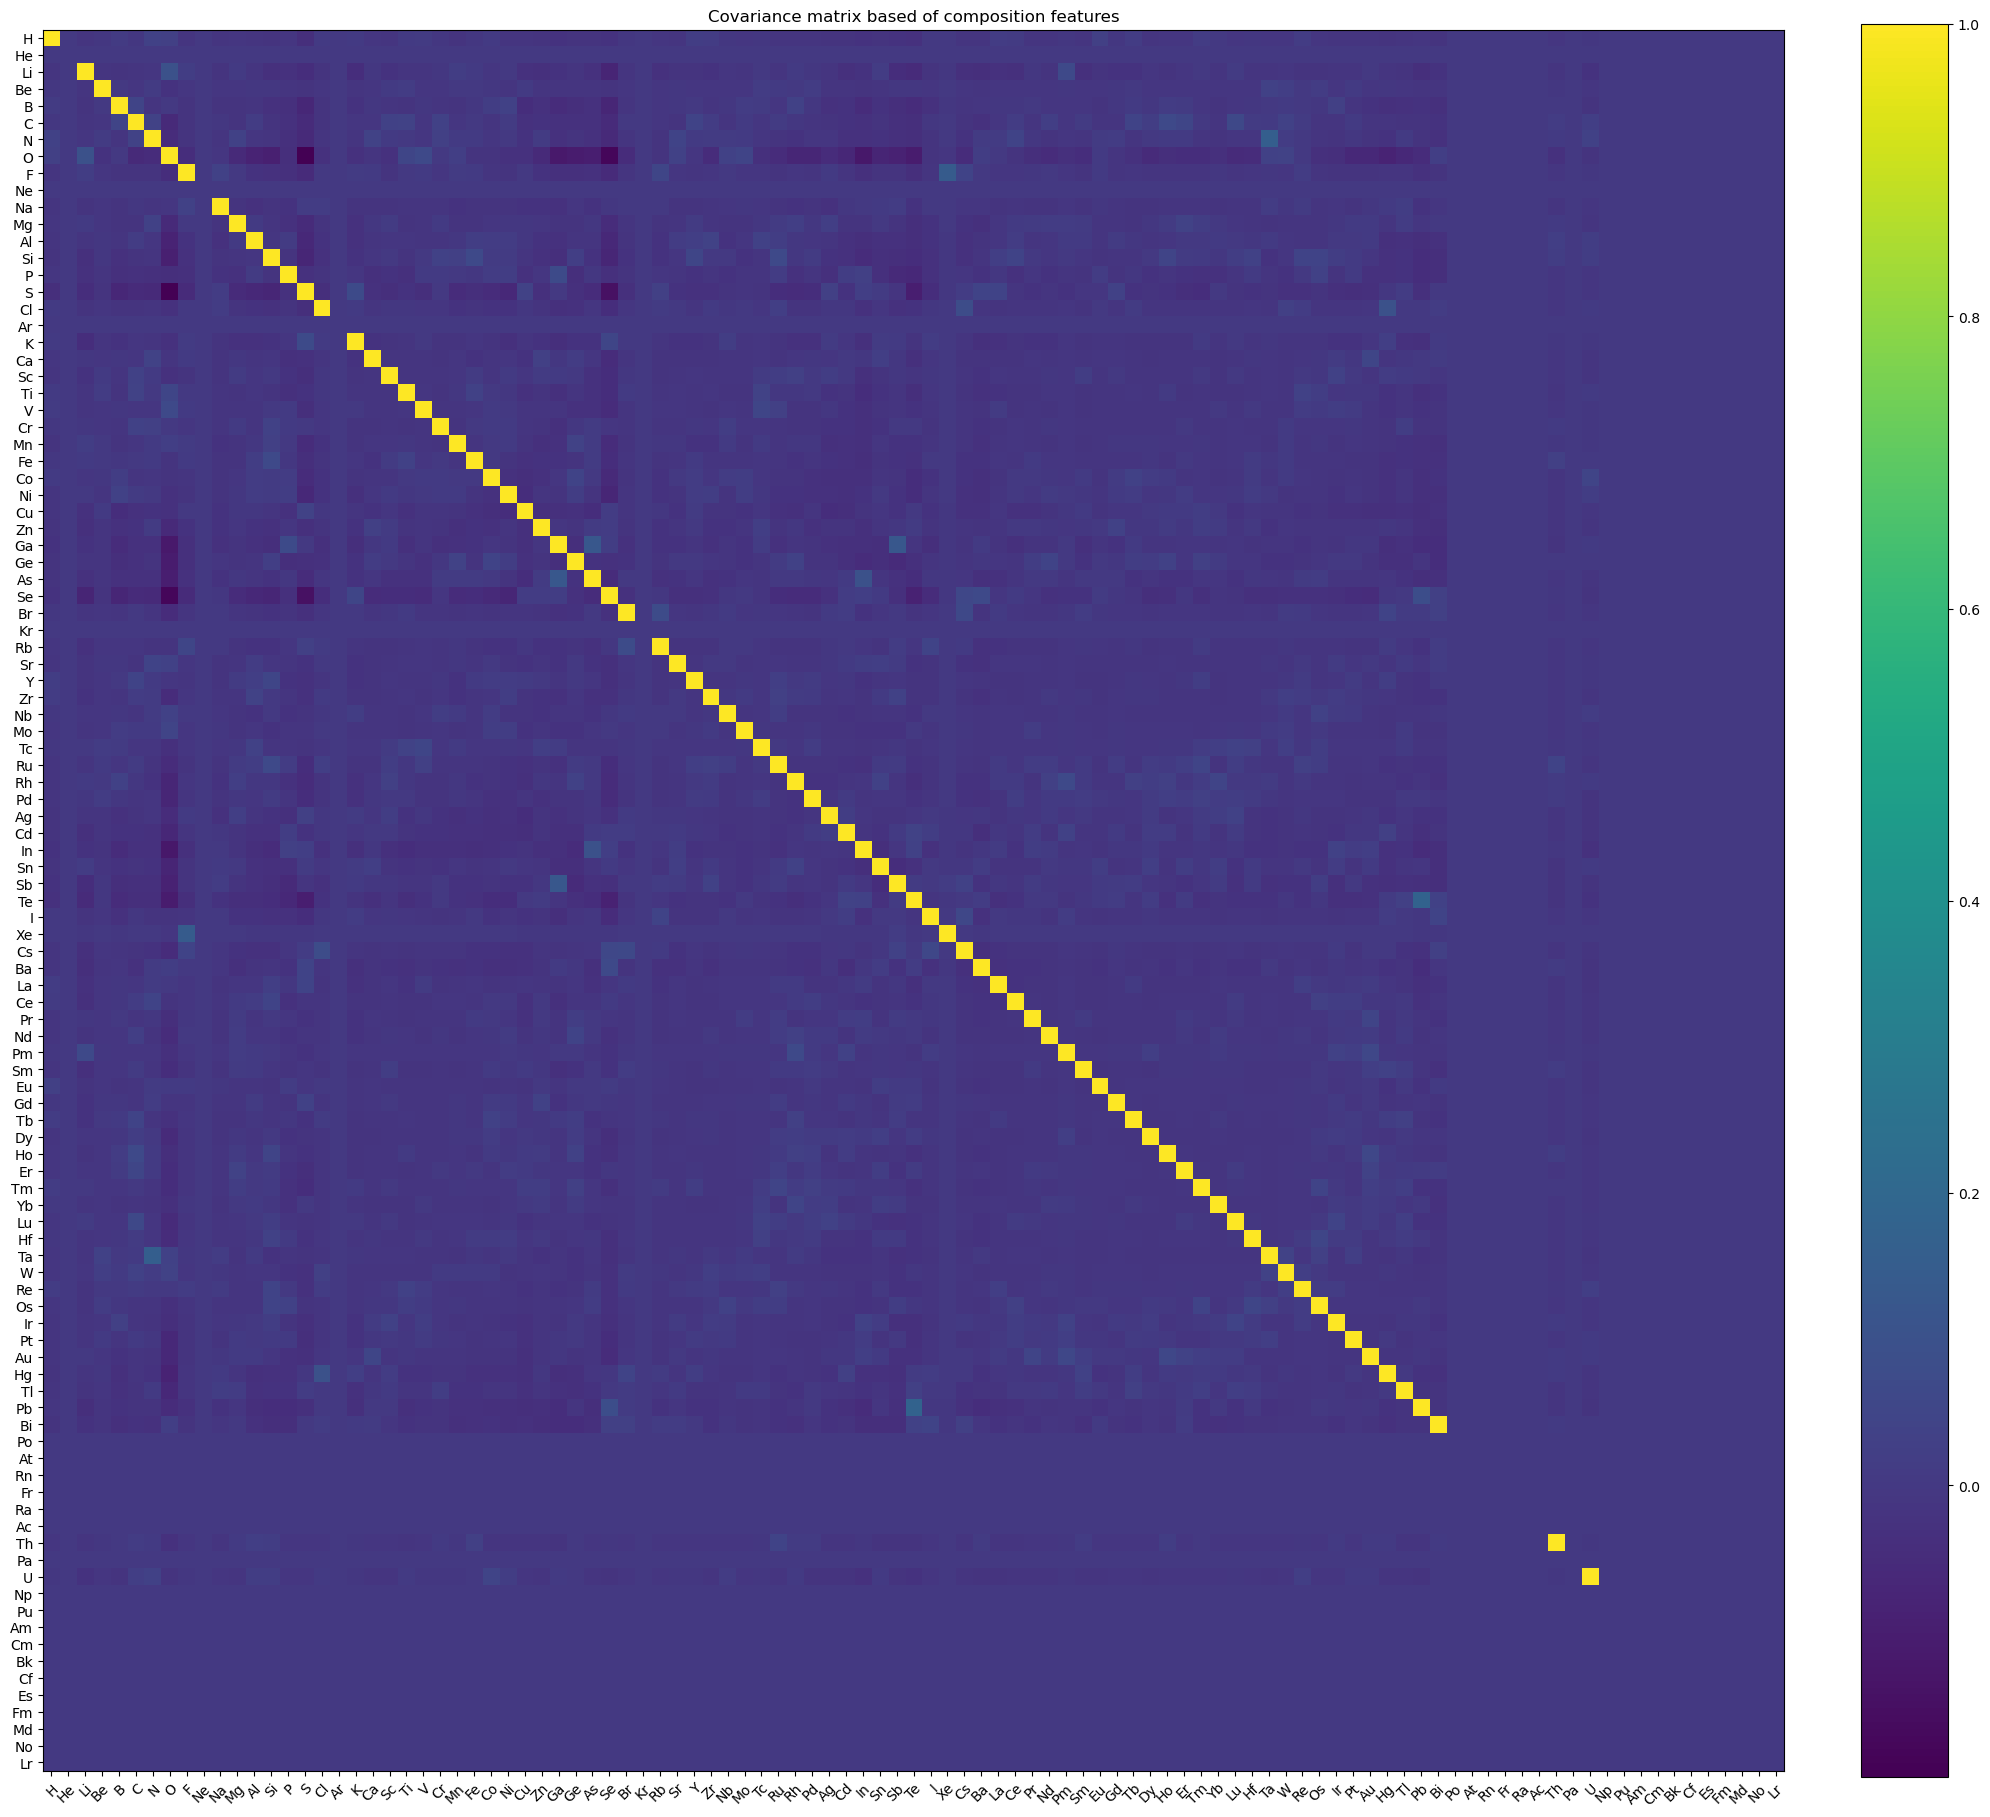

In [8]:
Cov_X_m=np.cov(X_standard,rowvar=False)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(Cov_X_m)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(np.shape(X_standard)[1]), labels=X_standard.columns)
ax.set_yticks(np.arange(np.shape(X_standard)[1]), labels=X_standard.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Covariance matrix based of composition features")
plt.colorbar(im,fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()

In the next step, we perform the singular value decomposition of the covariance matrix, i.e. we will determine $\lambda$ and $v$ for which $$Cov_X \cdot v = \lambda v$$
Use the function [__eigh__](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html) from numpy.linalg. Compute the explained variance ratio for the eigenvalues (singular values) and sort these in descending order.

In [9]:
# Determine eigenvalues and eigenvectors
egnvalues, egnvectors = eigh(Cov_X_m)
evr=egnvalues/np.sum(egnvalues)
sorted_idx = (evr).argsort()[::-1]

Plot the explained variance ratio in the cumulative scree plot. Include a vertical line to highlight at which number of principal components 99% of the variance are explained.

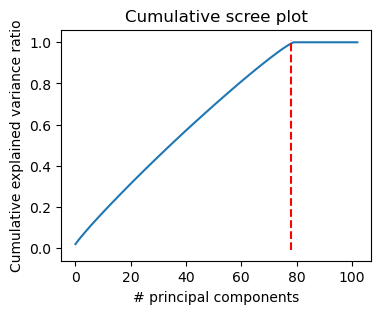

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(np.arange(len(evr)),np.cumsum(evr[sorted_idx]))
plt.plot([np.min(np.where(np.cumsum(evr[sorted_idx])>0.99)),np.min(np.where(np.cumsum(evr[sorted_idx])>0.99))],[-0.01,1.01],color='red',linestyle='dashed')
plt.title('Cumulative scree plot')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('# principal components')
plt.show()
#print(pca.explained_variance_ratio_)

Thus, instead of using the 103 features for predicting metallicity, we could transform them into their 78 most relevant principal components.

### k-means clustering

All the work we have performed until now in terms of classification was supervised machine learning, i.e. where we trained our classifiers with ground truth training data to predict unknown test data sets. We can also perform unsupervised machine learning. In this respect, we may use [__k-means__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering, for example to cluster our metallicity dataset. Output the accuracy of the clusters you would predict. What are you observing?

In [11]:
kmeans = KMeans(n_clusters=2, random_state=1, n_init='auto').fit(X)
print('Accuracy of k-means clustering:', np.round(accuracy_score(kmeans.labels_,y),2))

Accuracy of k-means clustering: 0.6


In order to observe how k-means clustering and the elbow method works, we will use the iris dataset. Load the dataset and display sepal width vs. sepal length. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


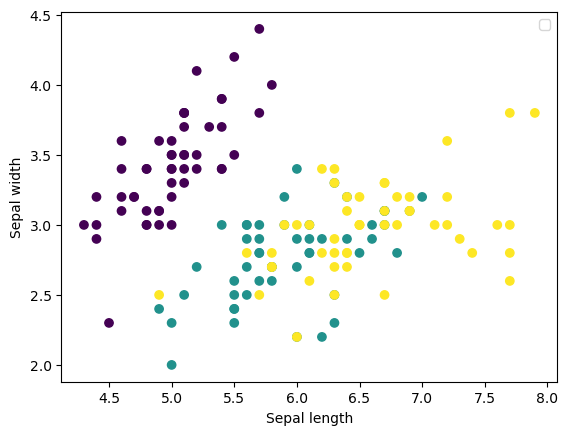

In [25]:
data = load_iris()
plt.scatter(data.data[:, 0], data.data[:, 1], c=data.target)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Perform the clustering for different $k$ and compute the distortion using __cdist__.

In [28]:
distortions = []
K = range(1, 10)
 
for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init='auto').fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\clust

Plot the distortion for different values of k. Which k would you select?

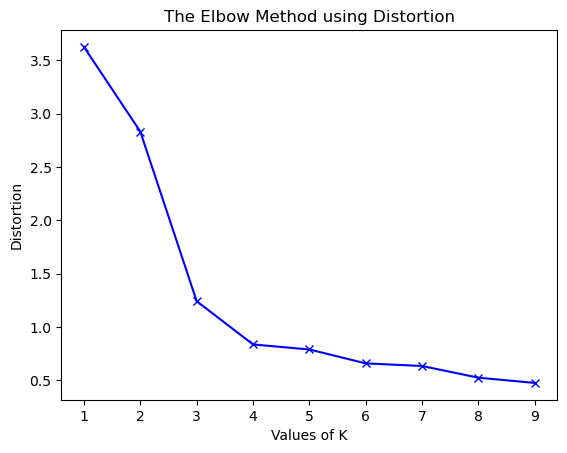

In [29]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Let's plot how the __kmeans__ clustering is finding the clusters during fitting for 3 clusters for the iris dataset.

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


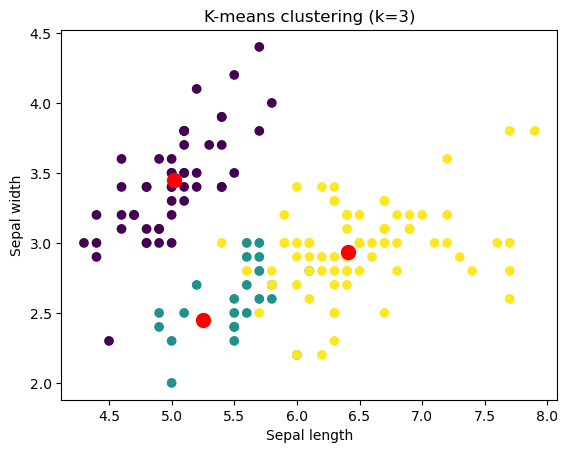

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


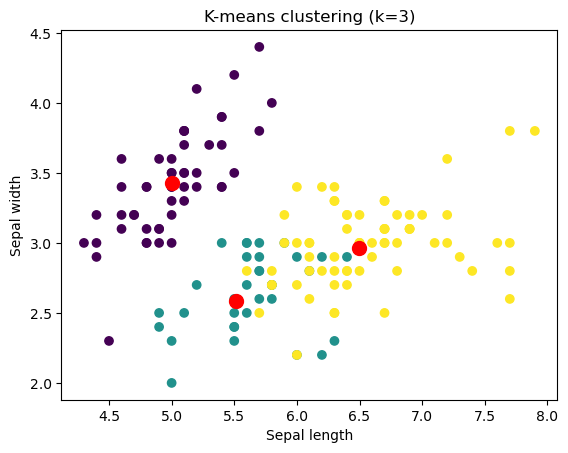

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


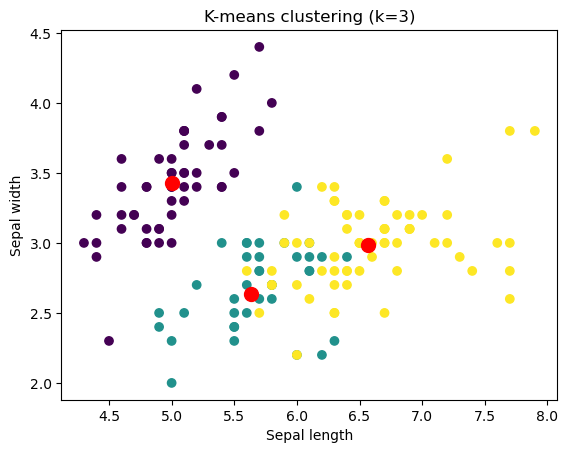

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


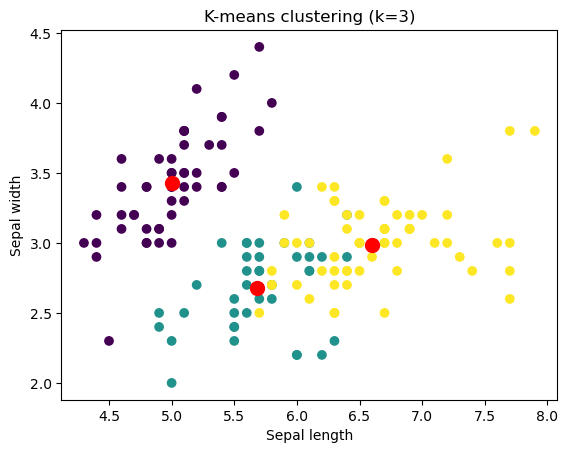

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


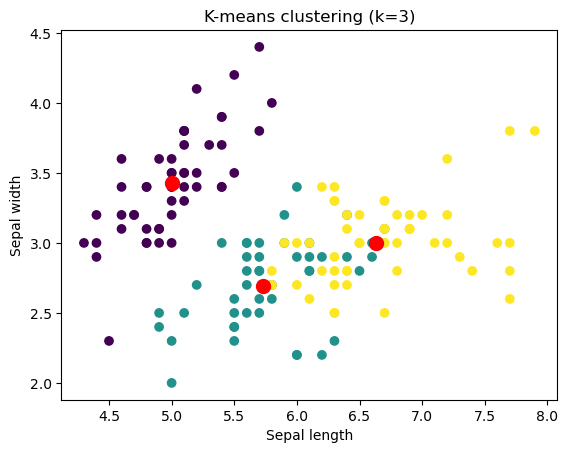

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


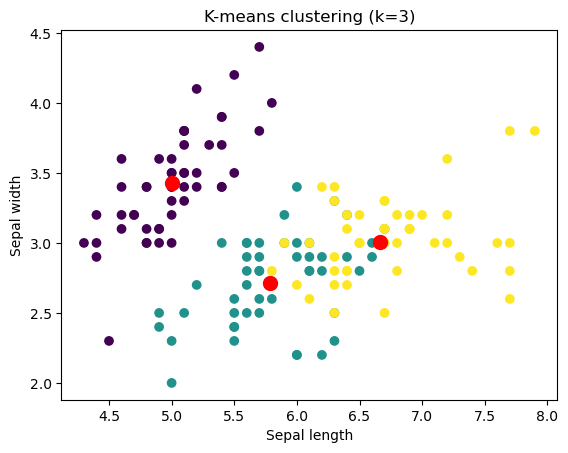

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


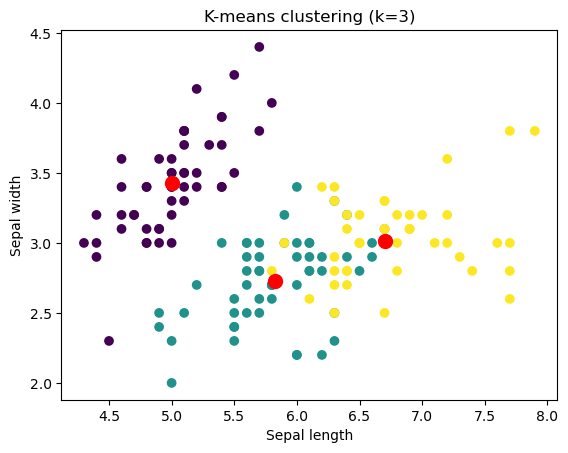

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


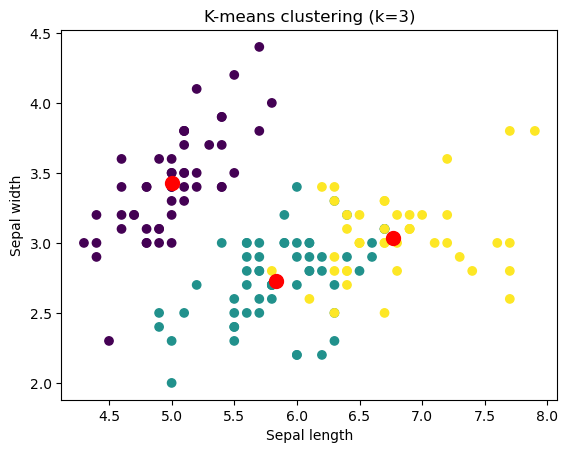

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


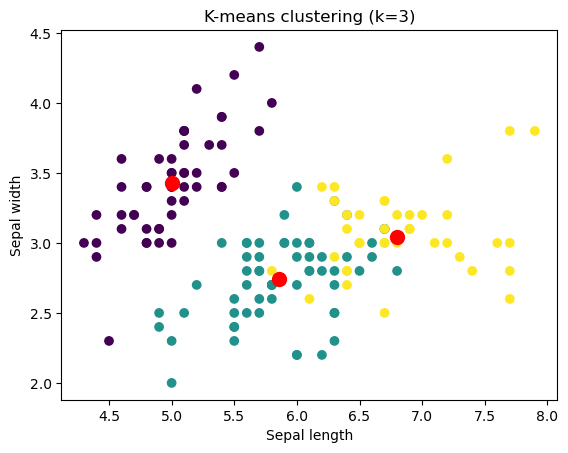

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


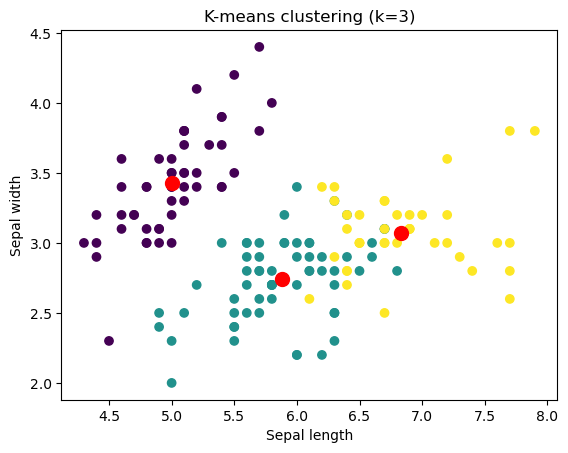

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


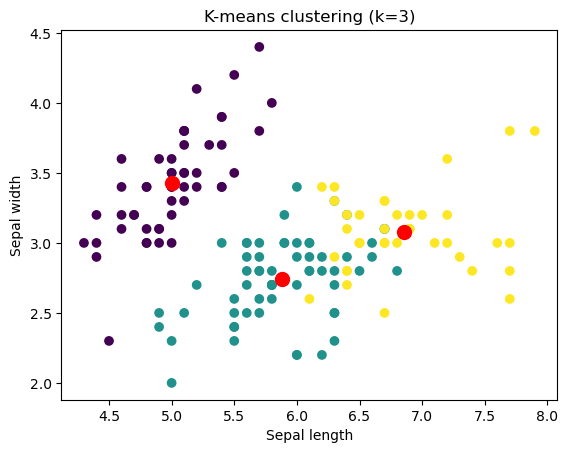

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


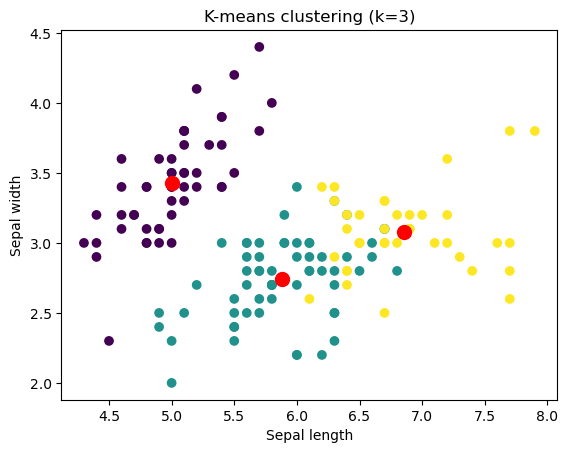

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


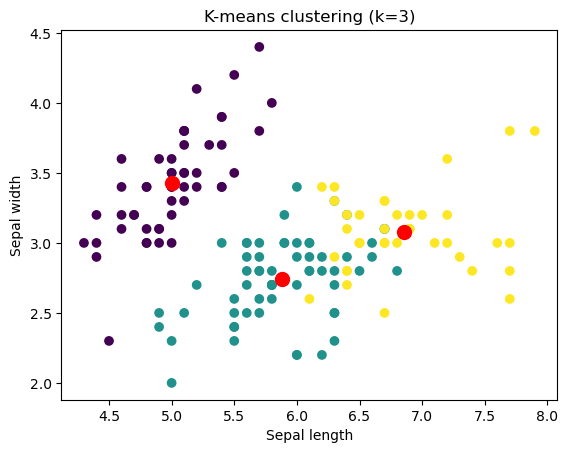

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


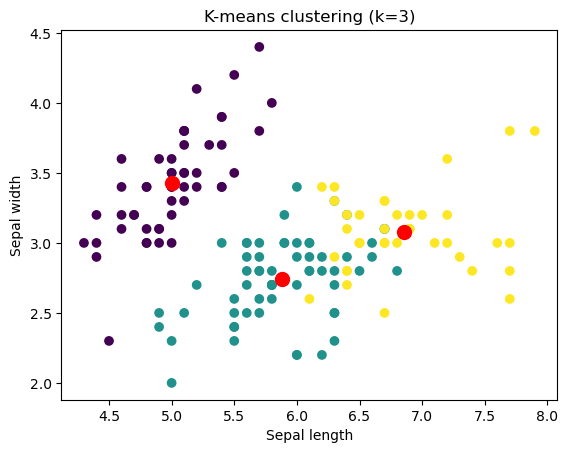

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


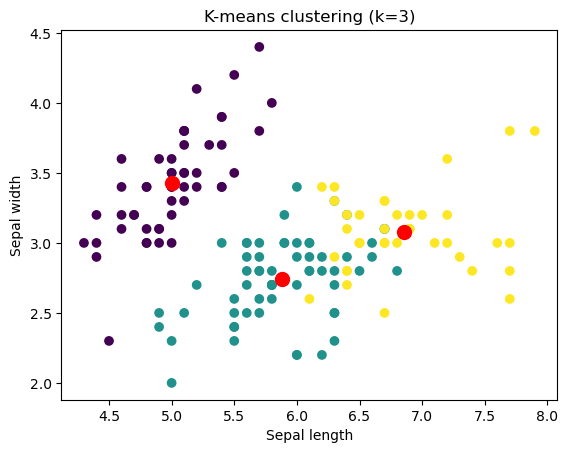

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


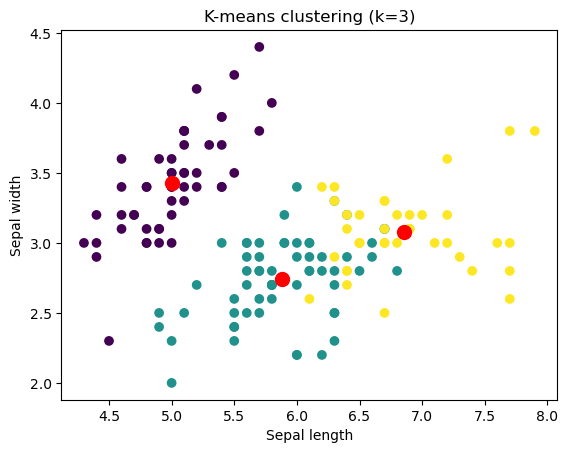

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


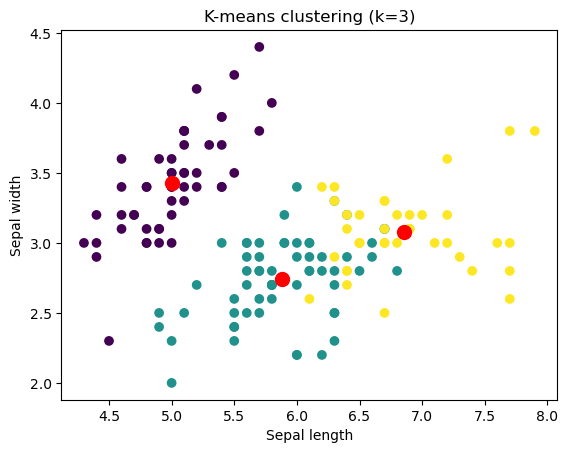

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


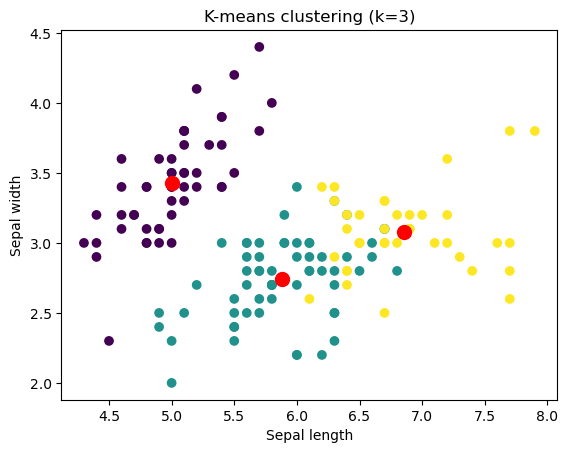

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


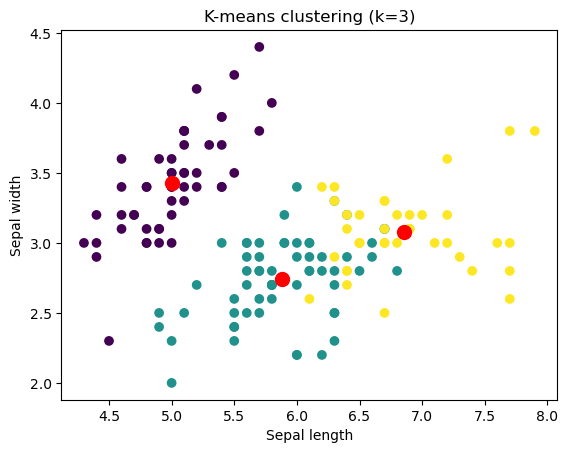

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


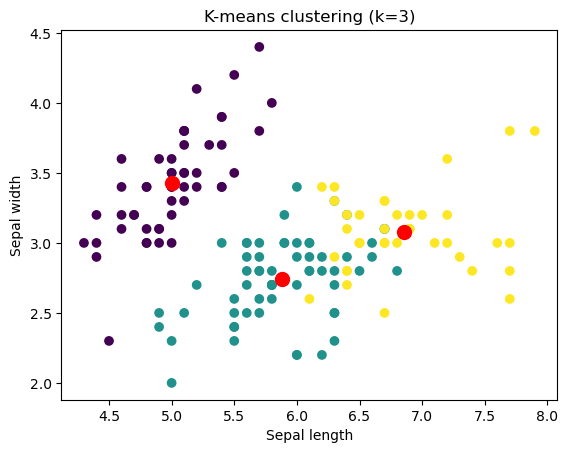

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


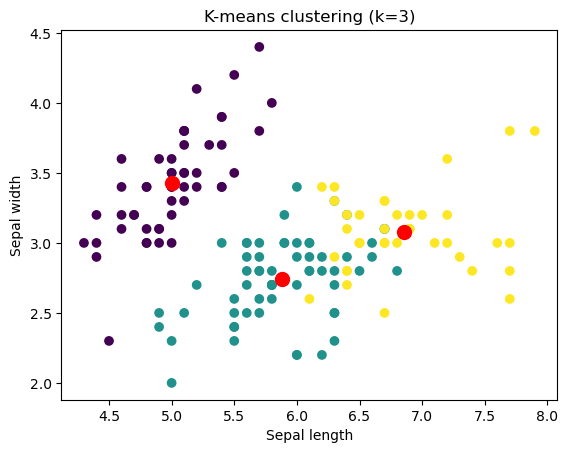

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


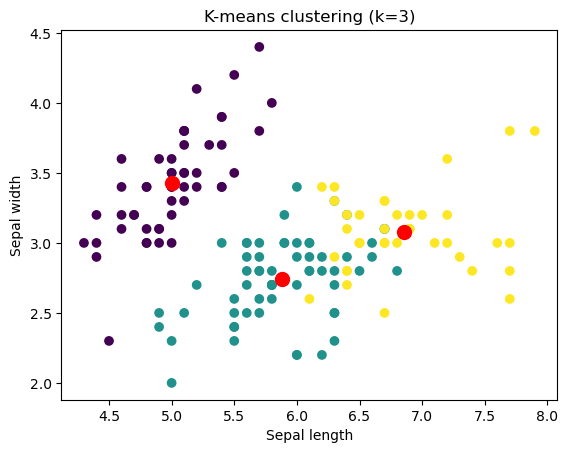

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


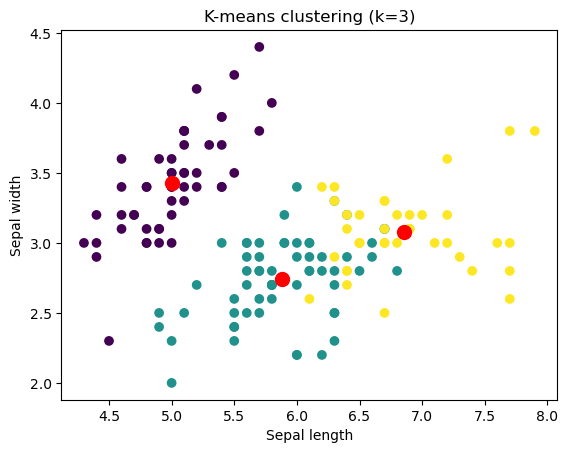

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


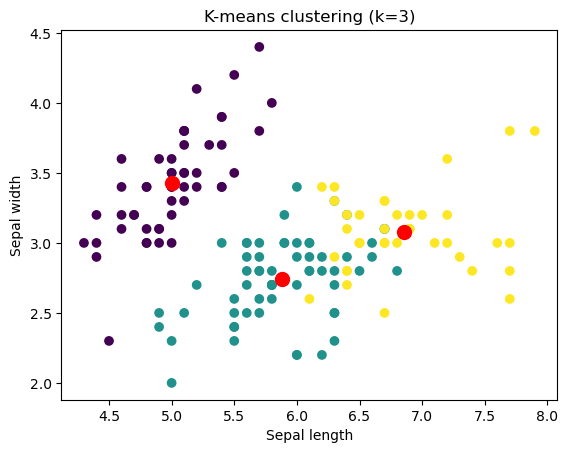

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


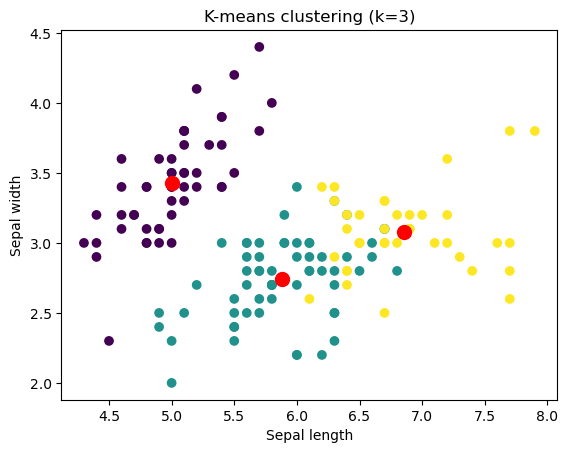

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


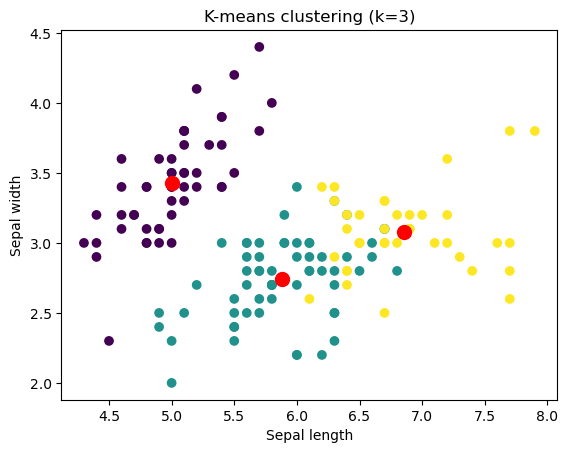

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


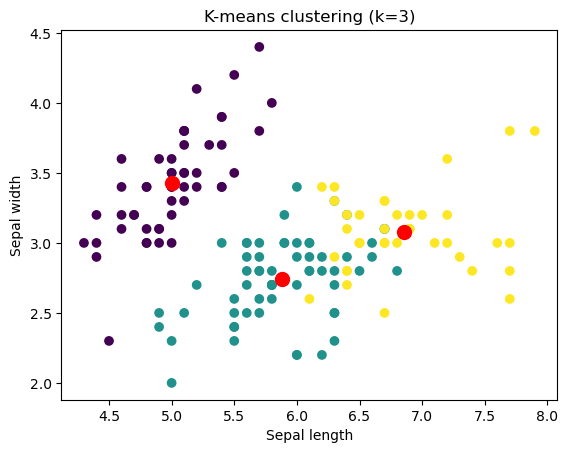

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


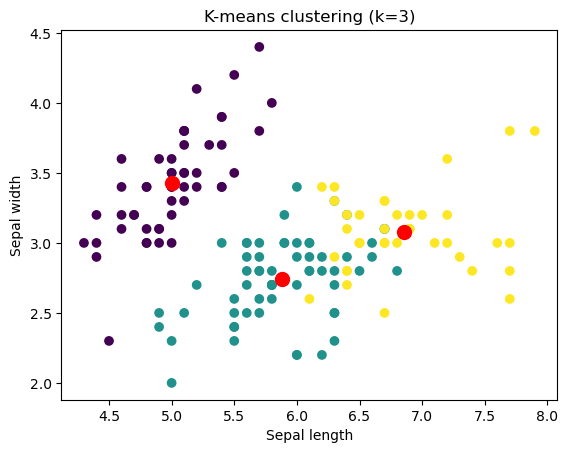

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


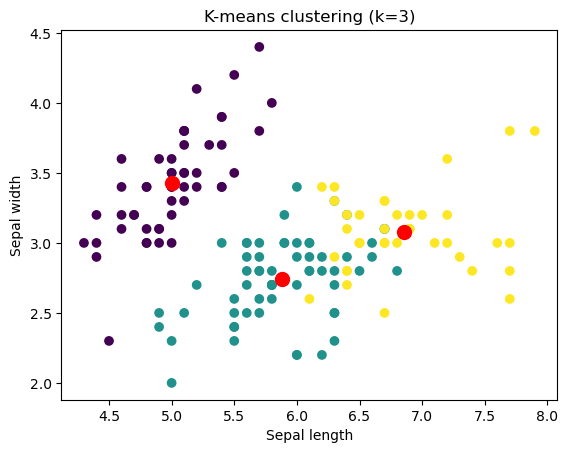

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


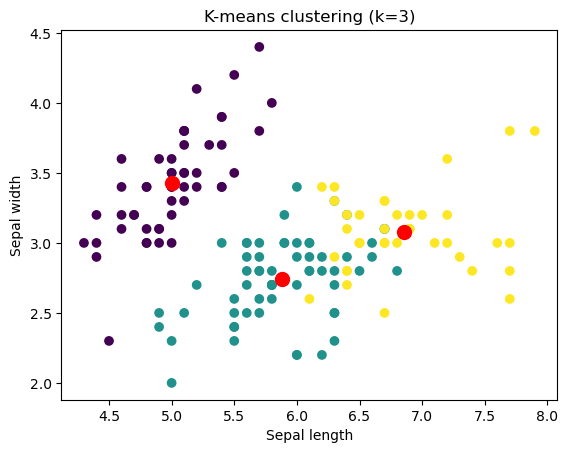

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


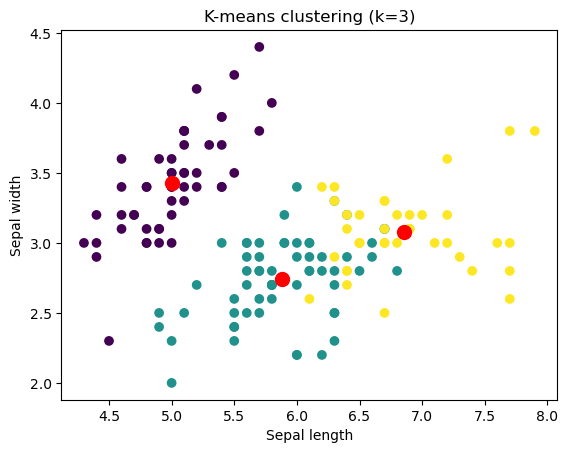

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


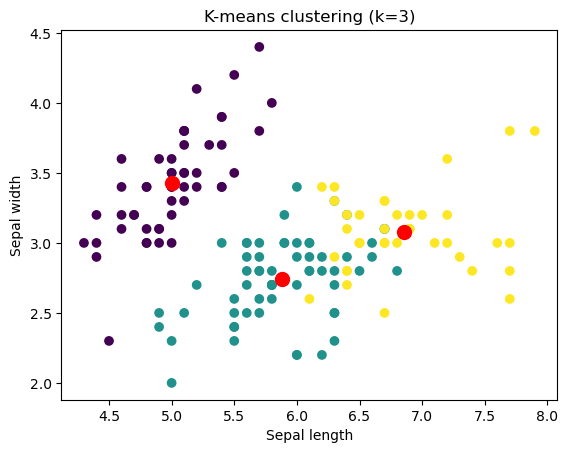

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


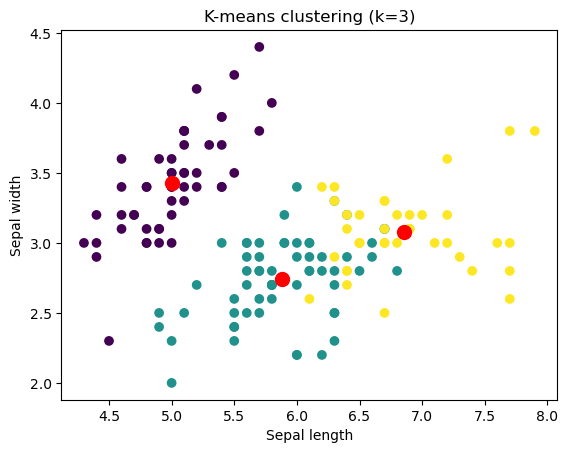

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


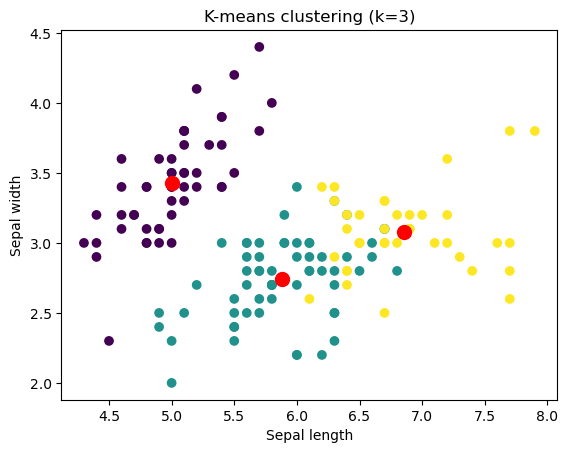

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


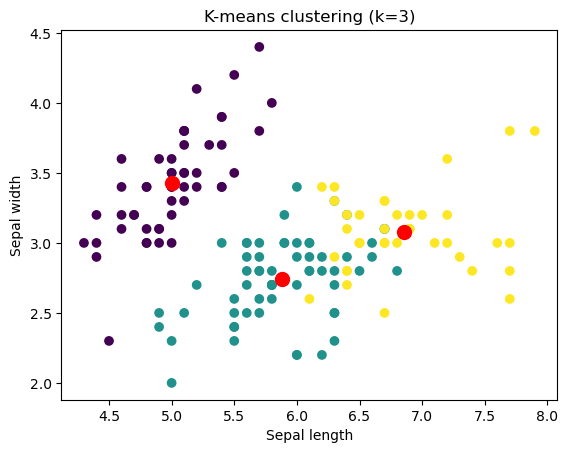

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


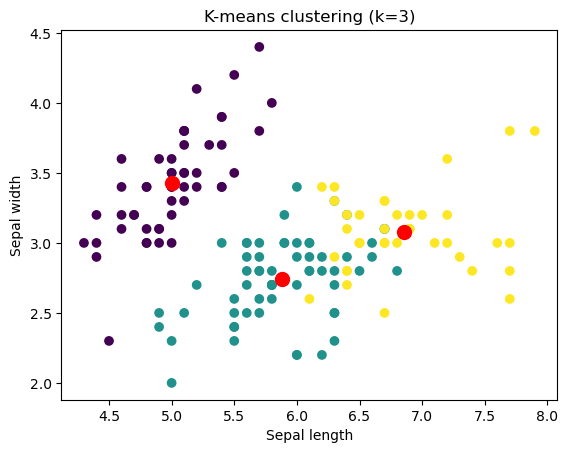

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


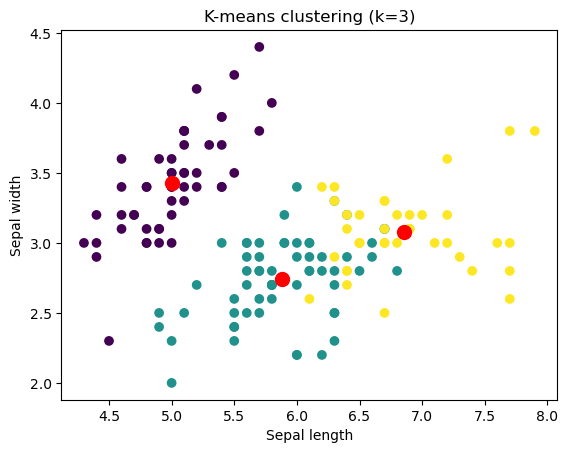

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


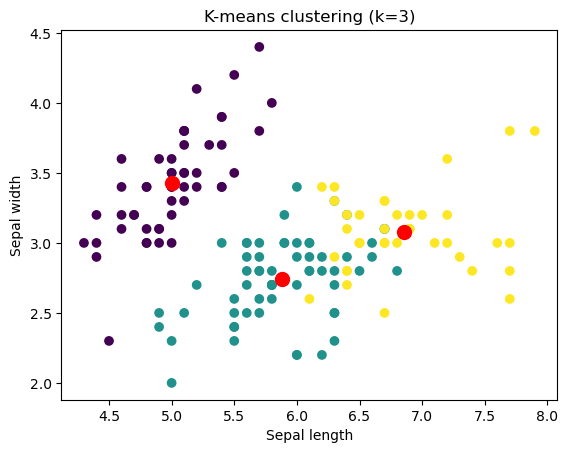

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


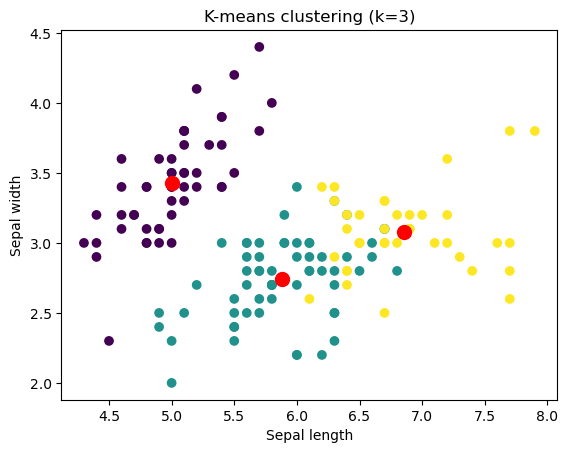

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


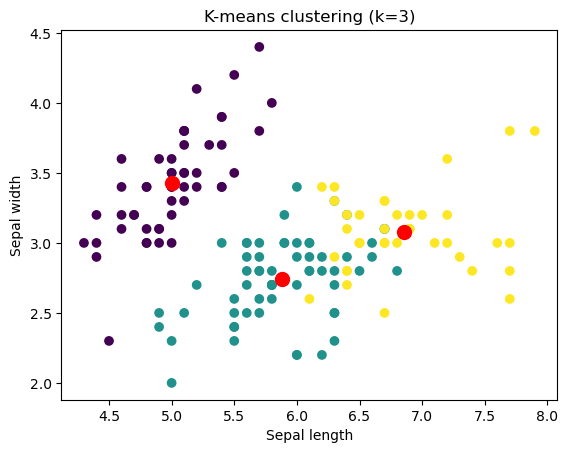

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


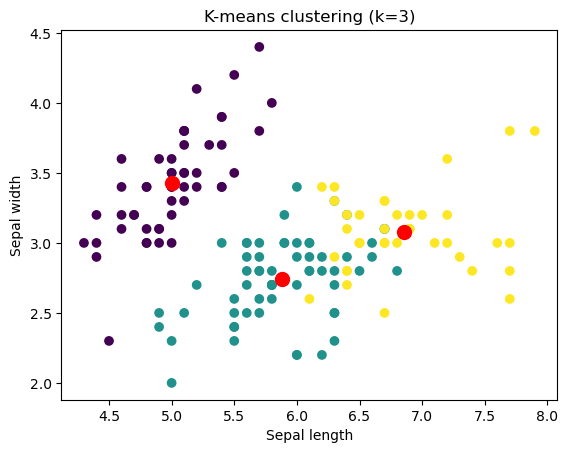

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


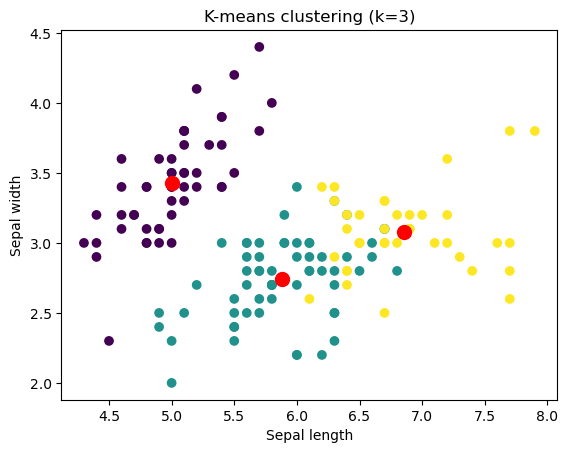

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


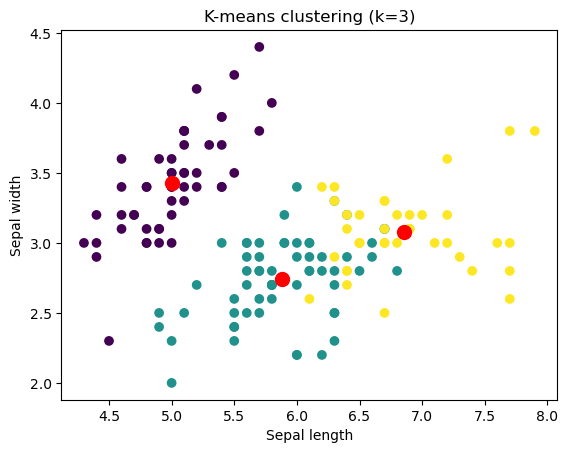

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


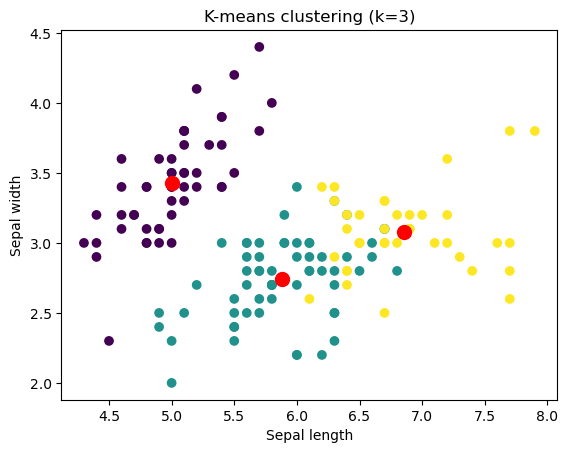

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


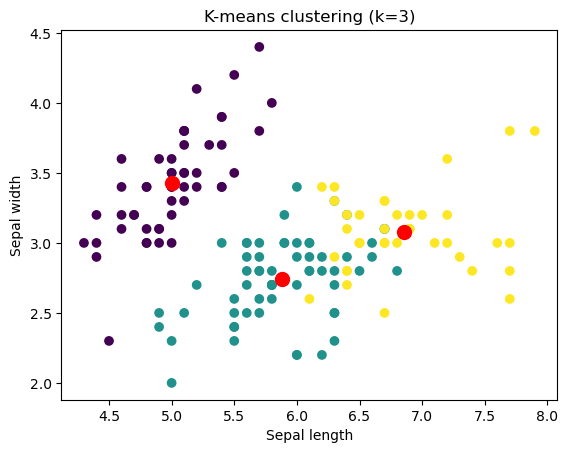

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


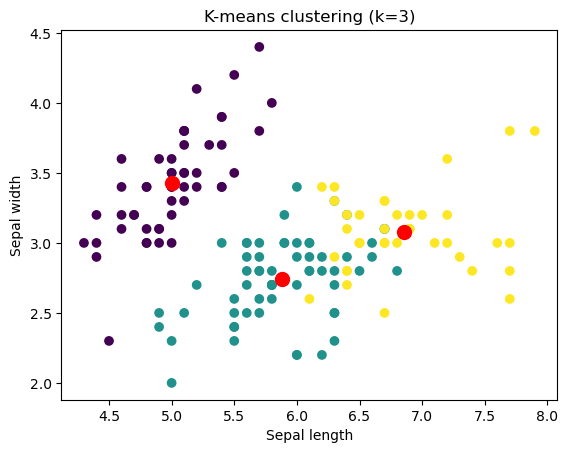

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


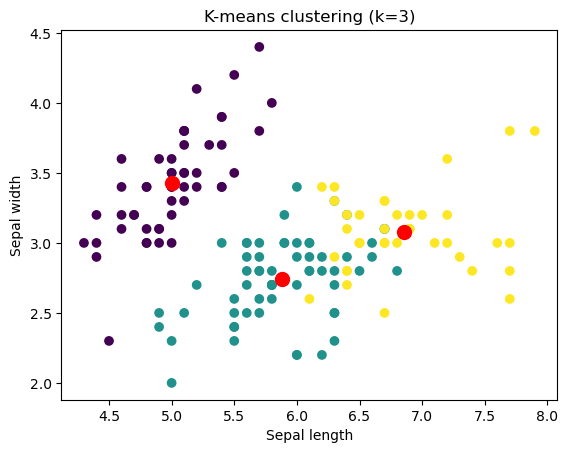

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


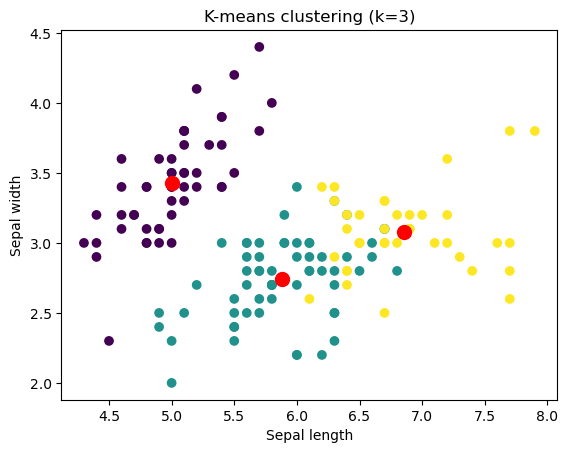

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


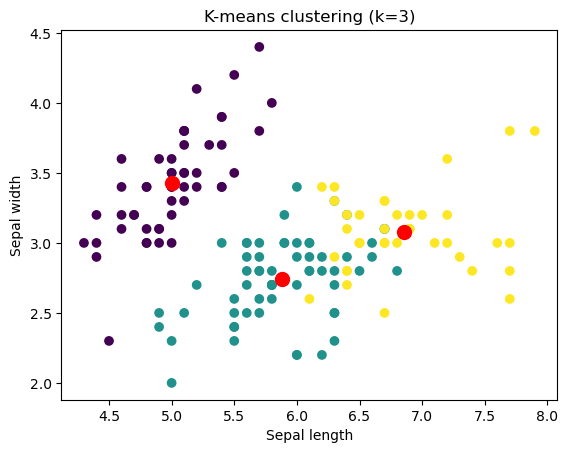

C:\Users\zellerb\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


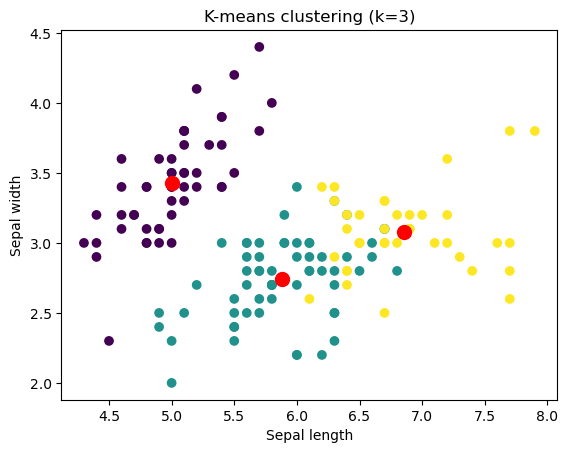

In [15]:
for i in range(1,51):
    kmeans = KMeans(n_clusters=3,init='random',n_init=1,max_iter=i,random_state=1)
    y_kmeans = kmeans.fit_predict(data.data)
    plt.scatter(data.data[:, 0], data.data[:, 1], c=y_kmeans)
    plt.scatter(kmeans.cluster_centers_[:, 0],\
        kmeans.cluster_centers_[:, 1], \
        s=100, c='red')
    plt.title('K-means clustering (k=3)')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.savefig('kmeans/kmeans_%s.png' % (i))
    plt.show()

<a name="cite_note-1"></a>1.[^](#cite_ref-1) Y. Zhuo, A.M. Tehrani, and J. Brgoch, J. Phys. Chem. Lett. 2018, 9, 7, 1668–1673, https://doi.org/10.1021/acs.jpclett.8b00124